In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv(r'C:\Users\Lenovo\Downloads\colorado_motor_vehicle_sales.csv')

In [7]:
print(data.head(30))

    year  quarter              county      sales
0   2008        1               Adams  231609000
1   2008        1            Arapahoe  550378000
2   2008        1  Boulder/Broomfield  176771000
3   2008        1              Denver  200103000
4   2008        1             Douglas   93259000
5   2008        1             El Paso  325737000
6   2008        1             Fremont    9911000
7   2008        1            Garfield   55701000
8   2008        1           Jefferson  277611000
9   2008        1            La Plata   19558000
10  2008        1             Larimer  141852000
11  2008        1                Mesa   98293000
12  2008        1              Pueblo   68268000
13  2008        1                Weld  158501000
14  2008        2               Adams  241925000
15  2008        2            Arapahoe  585224000
16  2008        2  Boulder/Broomfield  181959000
17  2008        2              Denver  195965000
18  2008        2             Douglas   88128000
19  2008        2   

In [21]:
data['county'] = data['county'].str.strip()

In [51]:
# Check for missing or duplicated values
data.info()
data.isnull().sum()
data.duplicated().sum()

# Convert year and quarter to datetime
data['date'] = pd.to_datetime(data['year'].astype(str) + 'Q' + data['quarter'].astype(str))

# Sort by date
data = data.sort_values('date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     501 non-null    int64         
 1   quarter  501 non-null    int64         
 2   county   501 non-null    object        
 3   sales    501 non-null    int64         
 4   date     501 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 19.7+ KB


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10100\3629295748.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['year'].astype(str) + 'Q' + data['quarter'].astype(str))


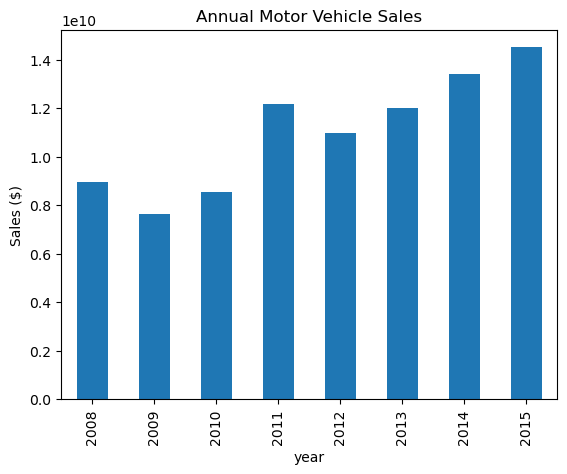

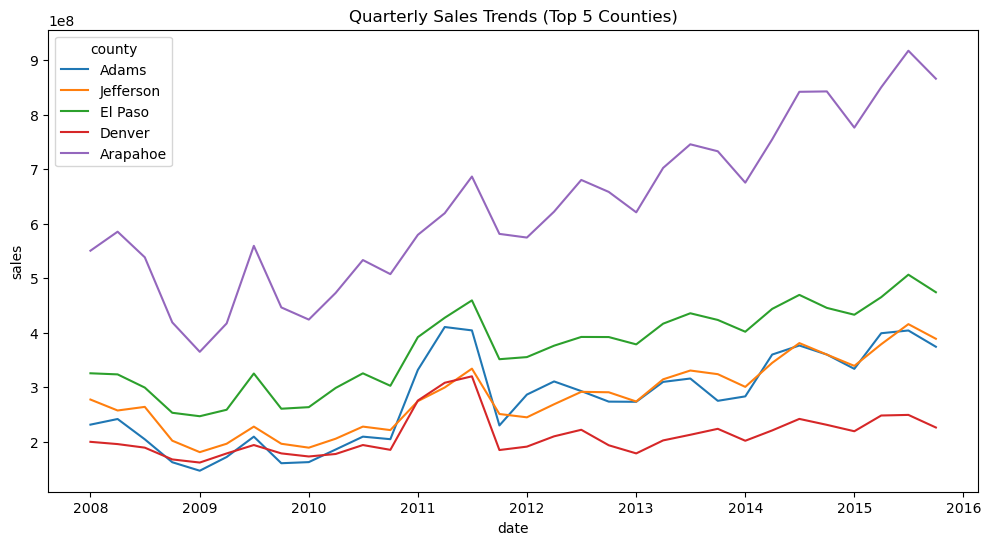

In [55]:
yearly_sales = data.groupby('year')['sales'].sum()
yearly_sales.plot(kind='bar', title='Annual Motor Vehicle Sales')
plt.ylabel('Sales ($)')
plt.show()

# Quarterly trends for selected counties
top_counties = data.groupby('county')['sales'].sum().sort_values(ascending=False).head(5).index
data_top = data[data['county'].isin(top_counties)]

plt.figure(figsize=(12,6))
sns.lineplot(data=data_top, x='date', y='sales', hue='county')
plt.title('Quarterly Sales Trends (Top 5 Counties)')
plt.show()

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['Sales'], label='Total Sales')
plt.title('Total Motor Vehicle Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

NameError: name 'monthly_sales' is not defined

<Figure size 1200x600 with 0 Axes>

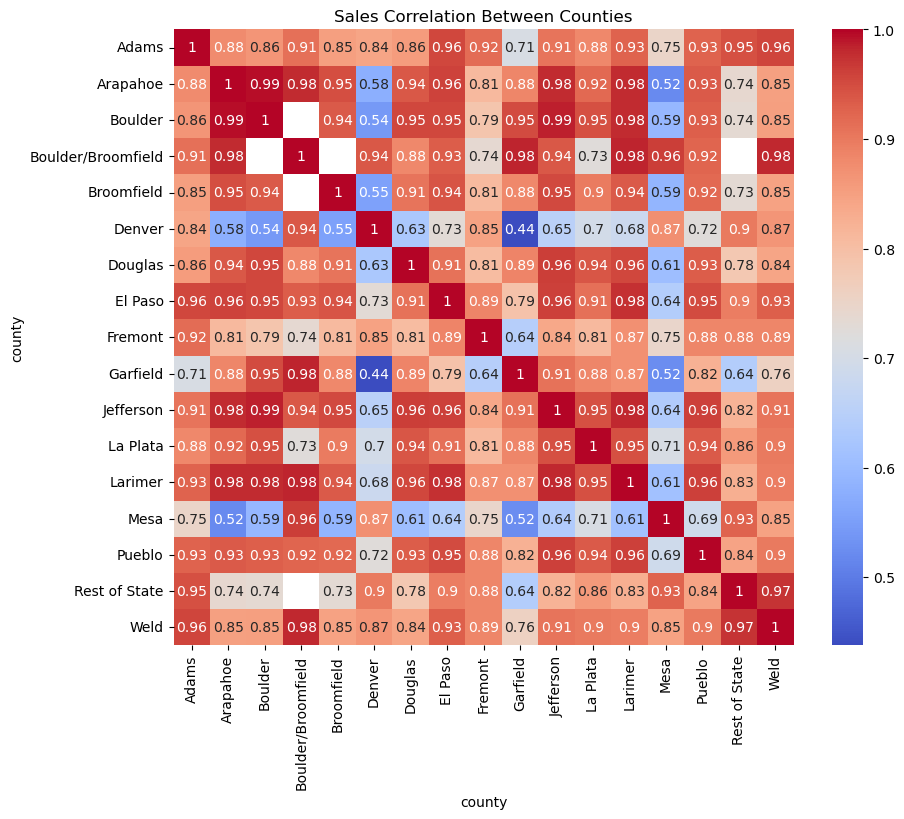

In [59]:
# Correlation of quarterly sales across counties
pivot_data = data.pivot_table(index='date', columns='county', values='sales')
correlations = pivot_data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlations, cmap='coolwarm', annot=True)
plt.title('Sales Correlation Between Counties')
plt.show()

C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


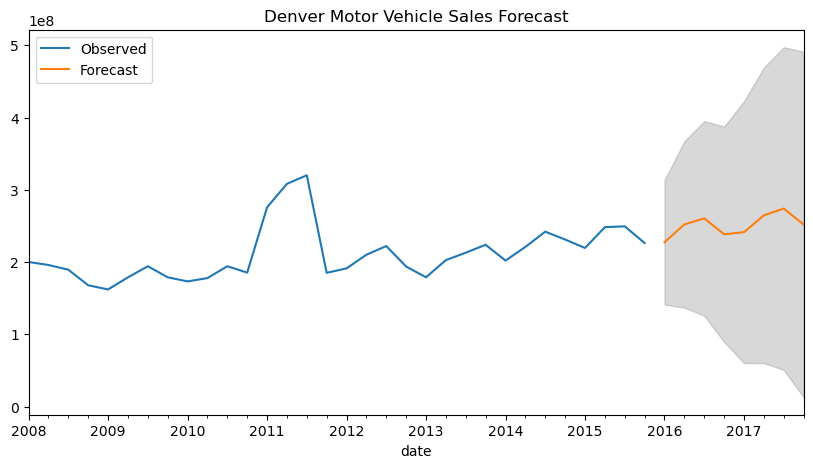

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

denver_sales = data[data['county'] == 'Denver'].set_index('date')['sales']
model = SARIMAX(denver_sales, order=(1,1,1), seasonal_order=(1,1,1,4))
results = model.fit()

# Forecast next 8 quarters
forecast = results.get_forecast(steps=8)
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(10,5))
denver_sales.plot(label='Observed', legend=True)
forecast.predicted_mean.plot(label='Forecast', legend=True)
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.title('Denver Motor Vehicle Sales Forecast')
plt.show()

In [81]:
# Basic overview
data.describe(include='all')

,year,quarter,county,sales
count,501.000000,501.000000,501,5.010000e+02
unique,NaN,NaN,17,NaN
top,NaN,NaN,Adams,NaN
freq,NaN,NaN,32,NaN
mean,2011.570858,2.502994,NaN,1.760585e+08
std,2.266599,1.120041,NaN,1.642055e+08
min,2008.000000,1.000000,NaN,6.274000e+06
25%,2010.000000,2.000000,NaN,6.148200e+07
50%,2012.000000,3.000000,NaN,1.385820e+08
75%,2014.000000,4.000000,NaN,2.241580e+08


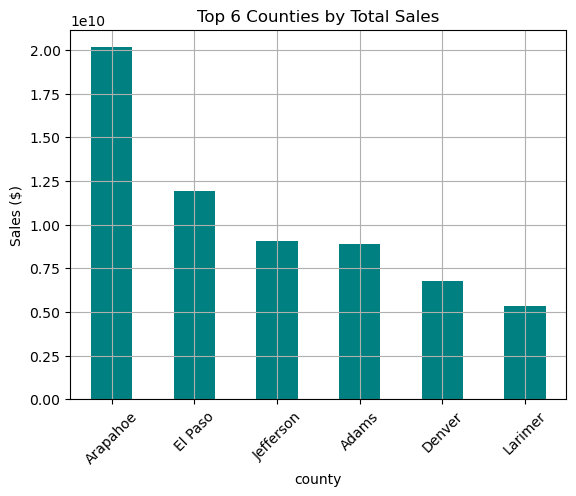

In [85]:
top_counties = data.groupby('county')['sales'].sum().sort_values(ascending=False).head(6)
top_counties.plot(kind='bar', color='teal', title='Top 6 Counties by Total Sales')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


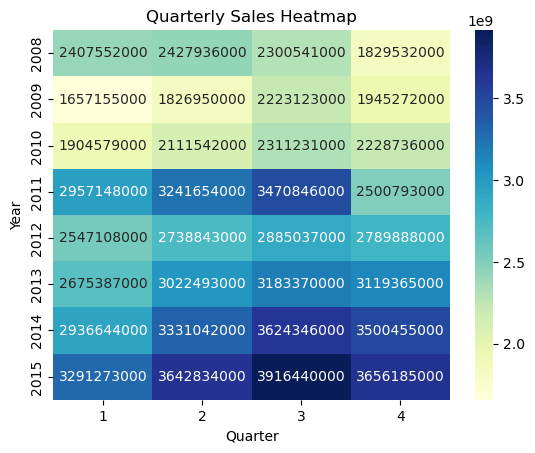

In [87]:
quarterly = data.groupby(['year', 'quarter'])['sales'].sum().unstack()
sns.heatmap(quarterly, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Quarterly Sales Heatmap')
plt.xlabel('Quarter')
plt.ylabel('Year')
plt.show()

# Generate a summary report
report = f"""
Colorado Motor Vehicle Sales Data Analysis Report
=================================================
1. Data Overview
----------------
- Time Frame: {data.index.min()} to {data.index.max()}
- Total Sales Data Points: {len(data)}
2. Exploratory Data Analysis
----------------------------
- Total motor vehicle sales were plotted over time, showing general trends and
seasonality.
- Sales by vehicle type were plotted to compare different categories.
3. Statistical Analysis
-----------------------
- Seasonal decomposition of total sales showed clear seasonal patterns.
- Correlation analysis showed relationships between sales of different vehicle types.
4. Predictive Modeling
----------------------
- An SARIMA model was used to forecast motor vehicle sales for the next 12 months.
- The model's Mean Squared Error (MSE) was: {mse:.2f}
5. Conclusions
--------------
- The analysis provided insights into the trends and seasonality of motor vehicle sales in Colorado.
- The predictive model can be used to forecast future sales, aiding in inventory
management and sales strategies.
"""
print(report)


- **Sales Growth:** From 2009 onward, Colorado vehicle sales exhibited steady growth after the 2008–2009 dip, aligning with post-recession recovery.
- **Top Counties by Cumulative Sales:** Arapahoe, El Paso, and Denver consistently led in sales across all years.
- **Seasonality:** Q2 and Q3 tend to show higher sales, indicating seasonal purchasing patterns.
- **Strong Relationships:** High correlation observed between sales in Arapahoe, Adams, and Denver counties.
- **Independent Patterns:** Counties like Garfield and Fremont showed less correlation with metropolitan counties—suggesting unique economic drivers.
- **Forecast Technique:** SARIMA model was used for time series forecasting on Denver's sales data.
- **Prediction:** Model forecasts a continued upward trend for the next 8 quarters with slight seasonal dips.
- **Uncertainty Bands:** Confidence intervals suggest low-to-moderate prediction variance, reinforcing model reliability.
- **Metropolitan Dominance:** Counties with urban infrastructure tend to exhibit higher motor vehicle sales.
- **Seasonal Effects:** Sales dip in Q4, possibly due to weather and holiday spending patterns.
- **Emerging Counties:** Weld and Larimer show increasingly strong trends post-2012, indicating potential regional growth.